In [1]:
import pickle as pkl    
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pcdet.ops.iou3d_nms import iou3d_nms_utils
import numpy as np
import tqdm

os.chdir('/home/cgriesbacher/thesis/3DTrans/')

### Load detection

In [2]:
dataset_names = ["AVLTruck", "AVLRooftop", "ZOD"]


#results paths
results_path_avltruck = "/home/cgriesbacher/thesis/3DTrans/output_okeanos/output/avltruck_models/pvrcnnpp/D6_50epochs/eval/epoch_50/val/avltruck/result.pkl"
results_path_avlrooftop = "/home/cgriesbacher/thesis/3DTrans/output_okeanos/output/avltruck_models/pvrcnnpp/D6_50epochs/eval/epoch_50/val/avlrooftop/result.pkl"
results_path_zod = "/home/cgriesbacher/thesis/3DTrans/output_okeanos/output/avltruck_models/pvrcnnpp/D6_50epochs/eval/epoch_50/val/zod/result.pkl"

#load the results and make a dataframe
with open(results_path_avltruck, 'rb') as f:
    results_avltruck = pkl.load(f)
with open(results_path_avlrooftop, 'rb') as f:
    results_avlrooftop = pkl.load(f)
with open(results_path_zod, 'rb') as f:
    results_zod = pkl.load(f)

#make a dataframe
import pandas as pd
df_avltruck = pd.DataFrame(results_avltruck)
df_avlrooftop = pd.DataFrame(results_avlrooftop)
df_zod = pd.DataFrame(results_zod)

#add a column with the dataset name
df_avltruck['dataset'] = dataset_names[0]
df_avlrooftop['dataset'] = dataset_names[1]
df_zod['dataset'] = dataset_names[2]


#make a dataframe with all results
df = pd.concat([df_avltruck, df_avlrooftop, df_zod], axis=0)
df = df.reset_index(drop=True)

cols_to_explode = ['name', 'score', 'boxes_lidar', 'pred_labels', 'dataset', 'frame_id']
exploded_list = [df[col].explode() for col in cols_to_explode]
exploded_df = pd.concat(exploded_list, axis=1)

# Adding non-exploded columns
for col in df.columns:
    if col not in cols_to_explode:
        exploded_df[col] = df[col].values[0]

# Reset index if needed
df_det_full = exploded_df.reset_index(drop=True)

#drop nans
prev_len = len(df_det_full)
df_det_full = df_det_full.dropna()
print("Dropped {} rows with NaNs".format(prev_len - len(df_det_full)))

Dropped 5 rows with NaNs


In [3]:
df_det_full.head()

,name,score,boxes_lidar,pred_labels,dataset,frame_id
0,Vehicle,0.996811,"[16.324436, 2.9960506, 1.2285396, 4.316964, 2....",1,AVLTruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...
1,Vehicle,0.992713,"[33.21999, 6.226522, 1.5767982, 3.8223252, 1.7...",1,AVLTruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...
2,Vehicle,0.984644,"[22.878384, 7.269121, 1.3874254, 3.89672, 1.79...",1,AVLTruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...
3,Vehicle,0.958693,"[13.747796, 8.703891, 1.1552413, 4.1951766, 1....",1,AVLTruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...
4,Truck,0.939998,"[53.74044, 3.8498654, 2.7586856, 5.8964276, 2....",4,AVLTruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...


### Load gt annotations

In [4]:
#annotation paths
annotation_path_avltruck = "/home/cgriesbacher/thesis/3DTrans/data/avltruck/avl_infos_val.pkl"
annotation_path_avlrooftop = "/home/cgriesbacher/thesis/3DTrans/data/avlrooftop/avl_infos_val.pkl"
annotation_path_zod = "/home/cgriesbacher/thesis/3DTrans/data/zod/zod_infos_val_full.pkl"

#load the annotations and make a dataframe
with open(annotation_path_avltruck, 'rb') as f:
    annotations_avltruck = pkl.load(f)
with open(annotation_path_avlrooftop, 'rb') as f:
    annotations_avlrooftop = pkl.load(f)
with open(annotation_path_zod, 'rb') as f:
    annotations_zod = pkl.load(f)

avltruck_content = []
for i in range(len(annotations_avltruck)):
    content = {}
    content["names"] = annotations_avltruck[i]["annos"]['name']
    content["gt_boxes_lidar"] = annotations_avltruck[i]["annos"]['gt_boxes_lidar']
    content['dataset'] = dataset_names[0]
    content['frame_id'] = annotations_avltruck[i]["point_cloud"]['lidar_idx']
    avltruck_content.append(content)

avlrooftop_content = []
for i in range(len(annotations_avlrooftop)):
    content = {}
    content["names"] = annotations_avlrooftop[i]["annos"]['name']
    content["gt_boxes_lidar"] = annotations_avlrooftop[i]["annos"]['gt_boxes_lidar']
    content['dataset'] = dataset_names[1]
    content['frame_id'] = annotations_avlrooftop[i]["point_cloud"]['lidar_idx']
    avlrooftop_content.append(content)

zod_content = []
for i in range(len(annotations_zod)):
    content = {}
    content["names"] = annotations_zod[i]["annos"]['name']
    content["gt_boxes_lidar"] = annotations_zod[i]["annos"]['gt_boxes_lidar']
    content['dataset'] = dataset_names[2]
    content['frame_id'] = annotations_zod[i]["point_cloud"]['lidar_idx']
    zod_content.append(content)

#make a dataframe
df_avltruck_annos = pd.DataFrame(avltruck_content)
df_avlrooftop_annos = pd.DataFrame(avlrooftop_content)
df_zod_annos = pd.DataFrame(zod_content)

#make a dataframe with all results
df_annos_full = pd.concat([df_avltruck_annos, df_avlrooftop_annos, df_zod_annos], axis=0) 
df_annos_full = df_annos_full.reset_index(drop=True)

#explode the lists
cols_to_explode = ['names', 'gt_boxes_lidar', 'dataset', 'frame_id']
df_annos_lists = [df_annos_full[col].explode() for col in cols_to_explode]
df_annos_full = pd.concat(df_annos_lists, axis=1)

prev_len = len(df_annos_full)
df_annos_full.dropna(inplace=True)
print(f"Dropped {prev_len - len(df_annos_full)} rows with NaNs")

Dropped 341 rows with NaNs


In [5]:
df_annos_full.head()

,names,gt_boxes_lidar,dataset,frame_id
0,Vehicle_Drivable_Car,"[-0.6930194629149725, 8.363328747338263, 0.874...",AVLTruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...
0,LargeVehicle_Truck,"[53.82803037810335, 3.8131357296285535, 2.8484...",AVLTruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...
0,Vehicle_Drivable_Car,"[2.2018114089068064, 8.611620962239865, 0.9723...",AVLTruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...
0,Vehicle_Drivable_Car,"[13.607684652969004, 8.77902886907815, 1.25697...",AVLTruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...
0,Vehicle_Drivable_Car,"[22.864224914545396, 7.301913520827088, 1.4405...",AVLTruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...


### calculate if each detection is a fp, tp, fn or tn using the ground truths with an iou threshold of 0.5

In [6]:

namemap_avltruck = {
    "Vehicle_Drivable_Car": "Vehicle",
    "Vehicle_Drivable_Van": "Vehicle",
    "Vehicle_Ridable_Motorcycle": "Cyclist",
    "Vehicle_Ridable_Bicycle": "Cyclist",
    "Human": "Pedestrian",
    "LargeVehicle_Bus": "Truck",
    "LargeVehicle_TruckCab": "Truck",
    "LargeVehicle_Truck": "Truck",
    "Trailer": "Truck",
    "Dont_Care": "DontCare",
    "Other": "DontCare",
    #'Placeholder': 'DontCare',
  }

namemap_avlrooftop =  {
    "Vehicle_Drivable_Car": "Vehicle",
    "Vehicle_Drivable_Van": "Vehicle",
    "LargeVehicle_Truck": "Truck",
    "LargeVehicle_TruckCab": "Truck",
    "LargeVehicle_Bus": "Truck",
    "LargeVehicle_Bus_Bendy": "Truck",
    "Trailer": "Truck",
    "Vehicle_Ridable_Motorcycle": "Cyclist",
    "Vehicle_Ridable_Bicycle": "Cyclist",
    "Human": "Pedestrian",
    "PPObject": "DontCare",
    "PPObject_Stroller": "DontCare",
    "Dont_care": "DontCare",
    #'Placeholder': 'DontCare',
  }

namemap_zod = {
    "Vehicle_Car": "Vehicle",
    "Vehicle_Van": "Vehicle",
    "Vehicle_Truck": "Truck",
    "Vehicle_Trailer": "Truck",
    "Vehicle_Bus": "Truck",
    "Vehicle_HeavyEquip": "Truck",
    "Vehicle_TramTrain": "Truck",
    "VulnerableVehicle_Motorcycle": "Cyclist",
    "VulnerableVehicle_Bicycle": "Cyclist",
    "Pedestrian": "Pedestrian",
    #'Placeholder': 'DontCare',
  }

#apply name maps for all data of each dataset
df_annos_full['names'] = df_annos_full['names'].apply(lambda x: namemap_avltruck[x] if x in namemap_avltruck.keys() else x)
df_annos_full['names'] = df_annos_full['names'].apply(lambda x: namemap_avlrooftop[x] if x in namemap_avlrooftop.keys() else x)
df_annos_full['names'] = df_annos_full['names'].apply(lambda x: namemap_zod[x] if x in namemap_zod.keys() else x)

#drop all dont cares
df_det_full = df_det_full[df_det_full['name'] != 'DontCare']

#add iou score to the dataframe, default is 0
df_det_full['iou'] = 0
df_annos_full['iou'] = 0

#to reduce runtime, sample 2k frame ids for each dataset
sampeled_df = pd.DataFrame()
sample_size = 1500
for dataset in dataset_names:
    frame_ids = df_det_full[df_det_full['dataset'] == dataset]['frame_id'].unique()
    frame_ids = np.random.choice(frame_ids, sample_size, replace=False)
    sample_df = df_det_full[df_det_full['frame_id'].isin(frame_ids)]
    sampeled_df = pd.concat([sampeled_df, sample_df], axis=0)

df_det = sampeled_df.reset_index(drop=True)
df_annos = df_annos_full
#det detection frame ids
det_frame_ids = df_det['frame_id'].unique()

# Loop over all frames
for det_frame_id in tqdm.tqdm(det_frame_ids):
    gt_anno = df_annos[df_annos['frame_id'] == det_frame_id]
    eval_det_annos = df_det[df_det['frame_id'] == det_frame_id]

    if len(gt_anno) == 0 or len(eval_det_annos) == 0:
        continue

    # Convert the boxes to numpy
    gt_boxes = np.stack(gt_anno["gt_boxes_lidar"].values)
    eval_det_boxes = np.stack(eval_det_annos["boxes_lidar"].values)
    
    # Get class-wise ious
    classes = eval_det_annos['name'].unique()
    for cls in classes:
        gt_mask = gt_anno['names'] == cls
        eval_det_mask = eval_det_annos['name'] == cls

        if len(gt_boxes[gt_mask.to_numpy()]) == 0 or len(eval_det_boxes[eval_det_mask.to_numpy()]) == 0:
            continue
        
        # Calculate the iou
        iou_matrix = iou3d_nms_utils.boxes_bev_iou_cpu(gt_boxes[gt_mask.to_numpy()], eval_det_boxes[eval_det_mask.to_numpy()])

        # Get the max iou for each det box
        max_ious_dets = np.max(iou_matrix, axis=0)

        # Get max_iou for each gt box
        max_ious_gts = np.max(iou_matrix, axis=1)
      
        # Update the iou score for each detection in the original DataFrame
        df_det.loc[eval_det_annos.index[eval_det_mask], 'iou'] = max_ious_dets

        # Update the iou score for each gt in the original DataFrame
        #df_annos.loc[gt_anno.index[gt_mask], 'iou'] = max_ious_gts


iou_thresholds = [0.3, 0.5, 0.7]

#for each detection, add detected_0.3, detected_0.5, detected_0.7
for iou_threshold in iou_thresholds:
    df_det[f'detected_{iou_threshold}'] = df_det['iou'] >= iou_threshold
    #gt_anno[f'detected_{iou_threshold}'] = gt_anno['iou'] >= iou_threshold

#print detections for each dataset and each iou threshold
for dataset in dataset_names:
        print(dataset)
        print("Detections for each iou threshold 0.7:")
        print(df_det[(df_det['dataset'] == dataset) & (df_det['detected_0.7'] == True)]['name'].value_counts())        

100%|██████████| 4500/4500 [01:52<00:00, 40.10it/s]

AVLTruck
Detections for each iou threshold 0.7:
Vehicle       8975
Truck         1205
Pedestrian     422
Cyclist        303
Name: name, dtype: int64
AVLRooftop
Detections for each iou threshold 0.7:
Vehicle       5429
Truck          619
Pedestrian      61
Cyclist         50
Name: name, dtype: int64
ZOD
Detections for each iou threshold 0.7:
Vehicle       9845
Pedestrian     525
Cyclist        458
Truck          380
Name: name, dtype: int64


classes are ['Vehicle' 'Truck' 'Cyclist' 'Pedestrian']


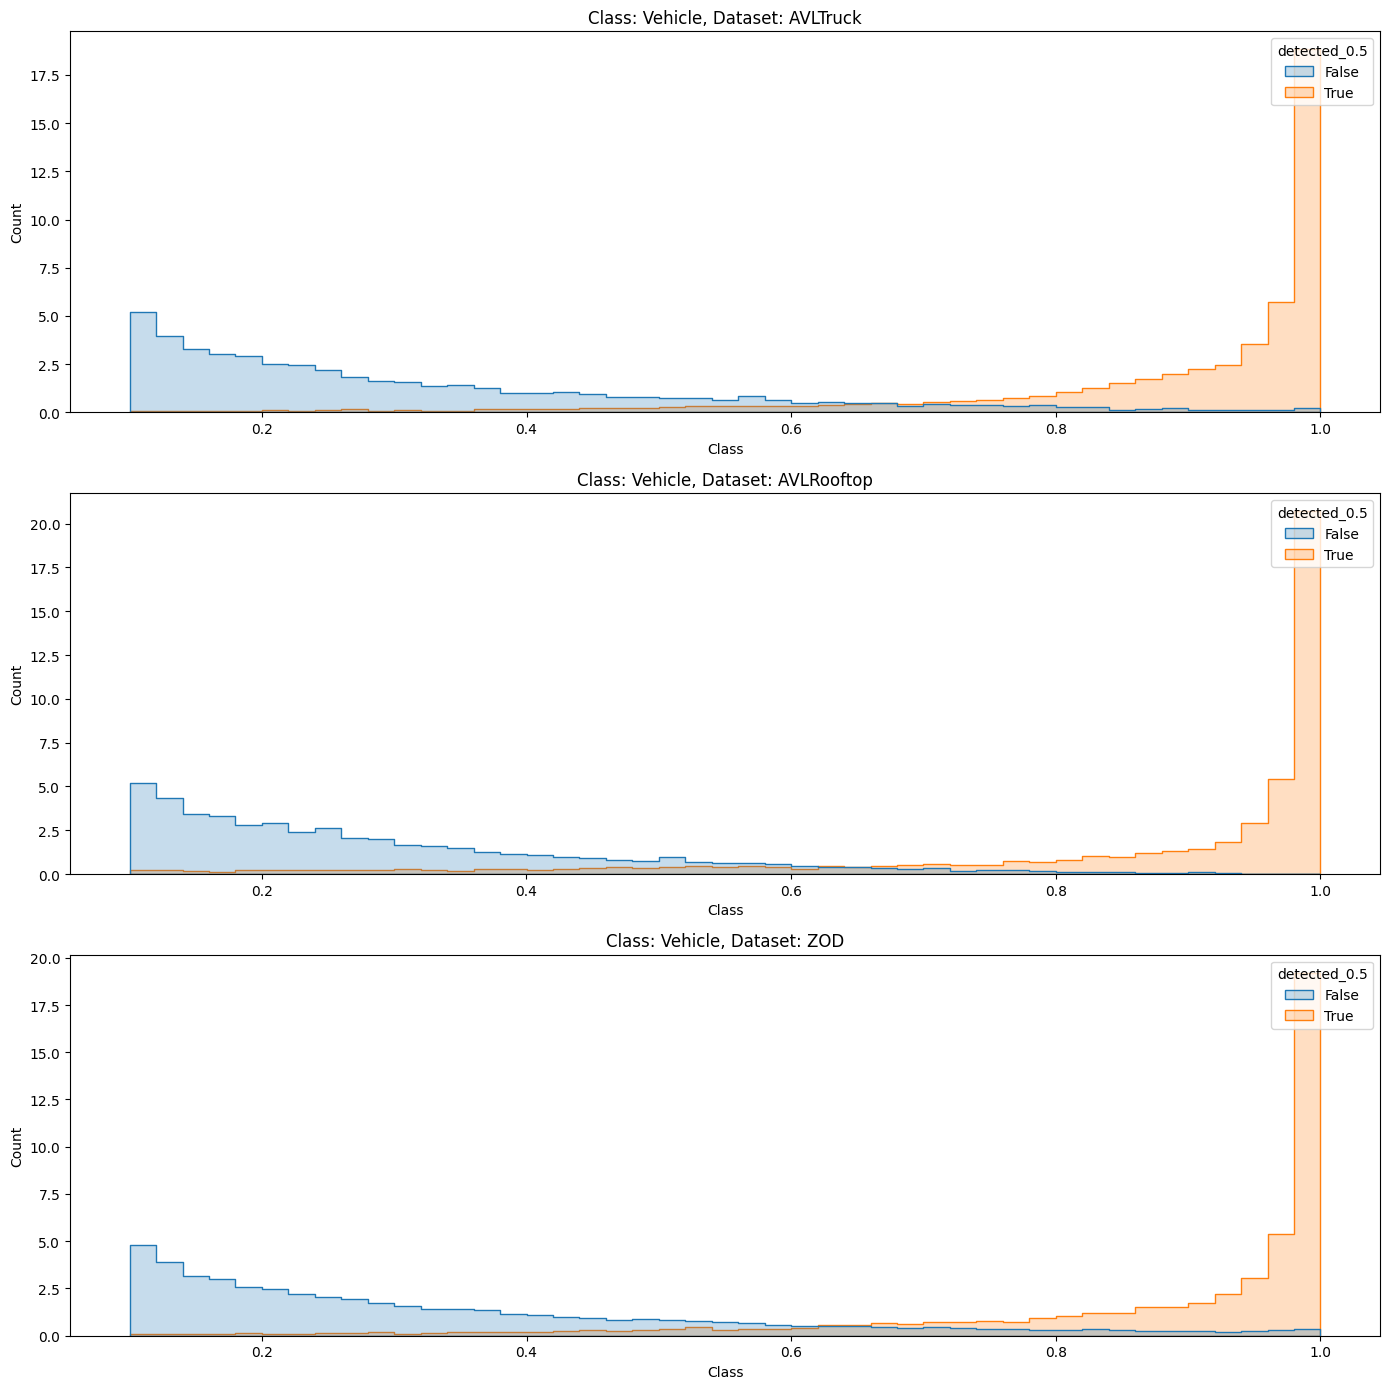

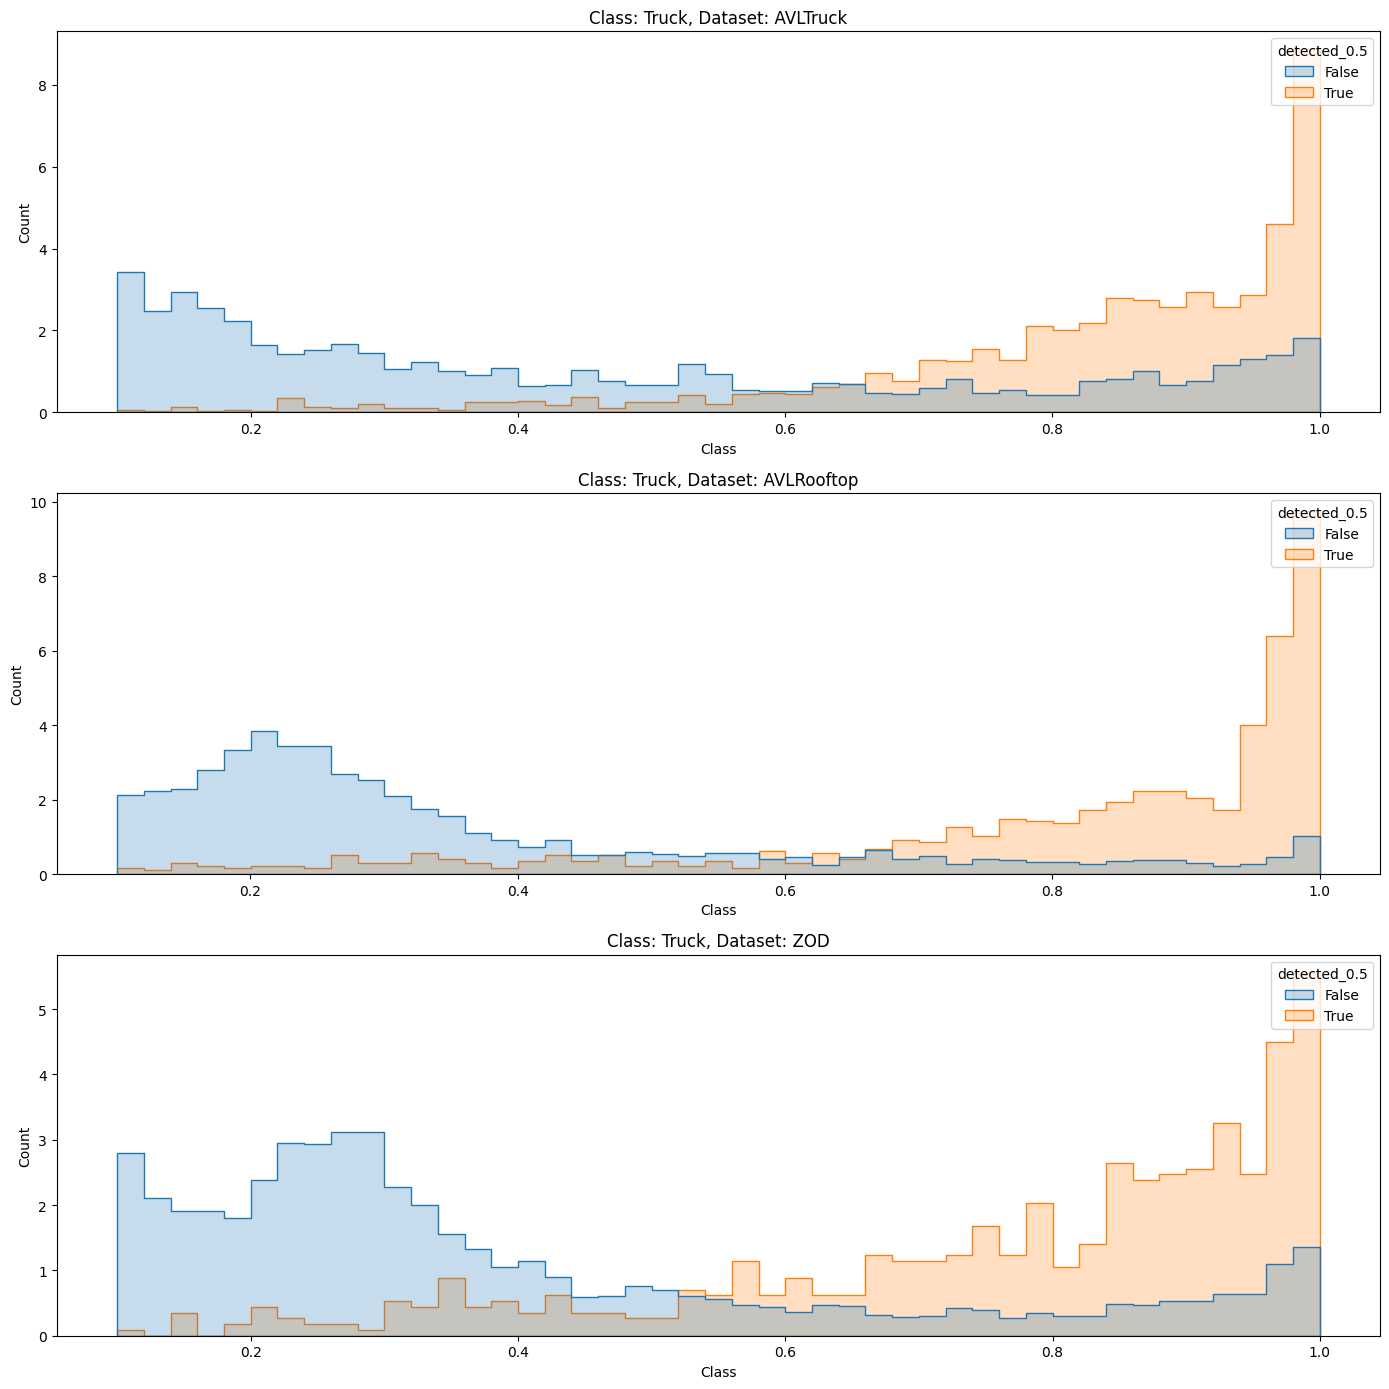

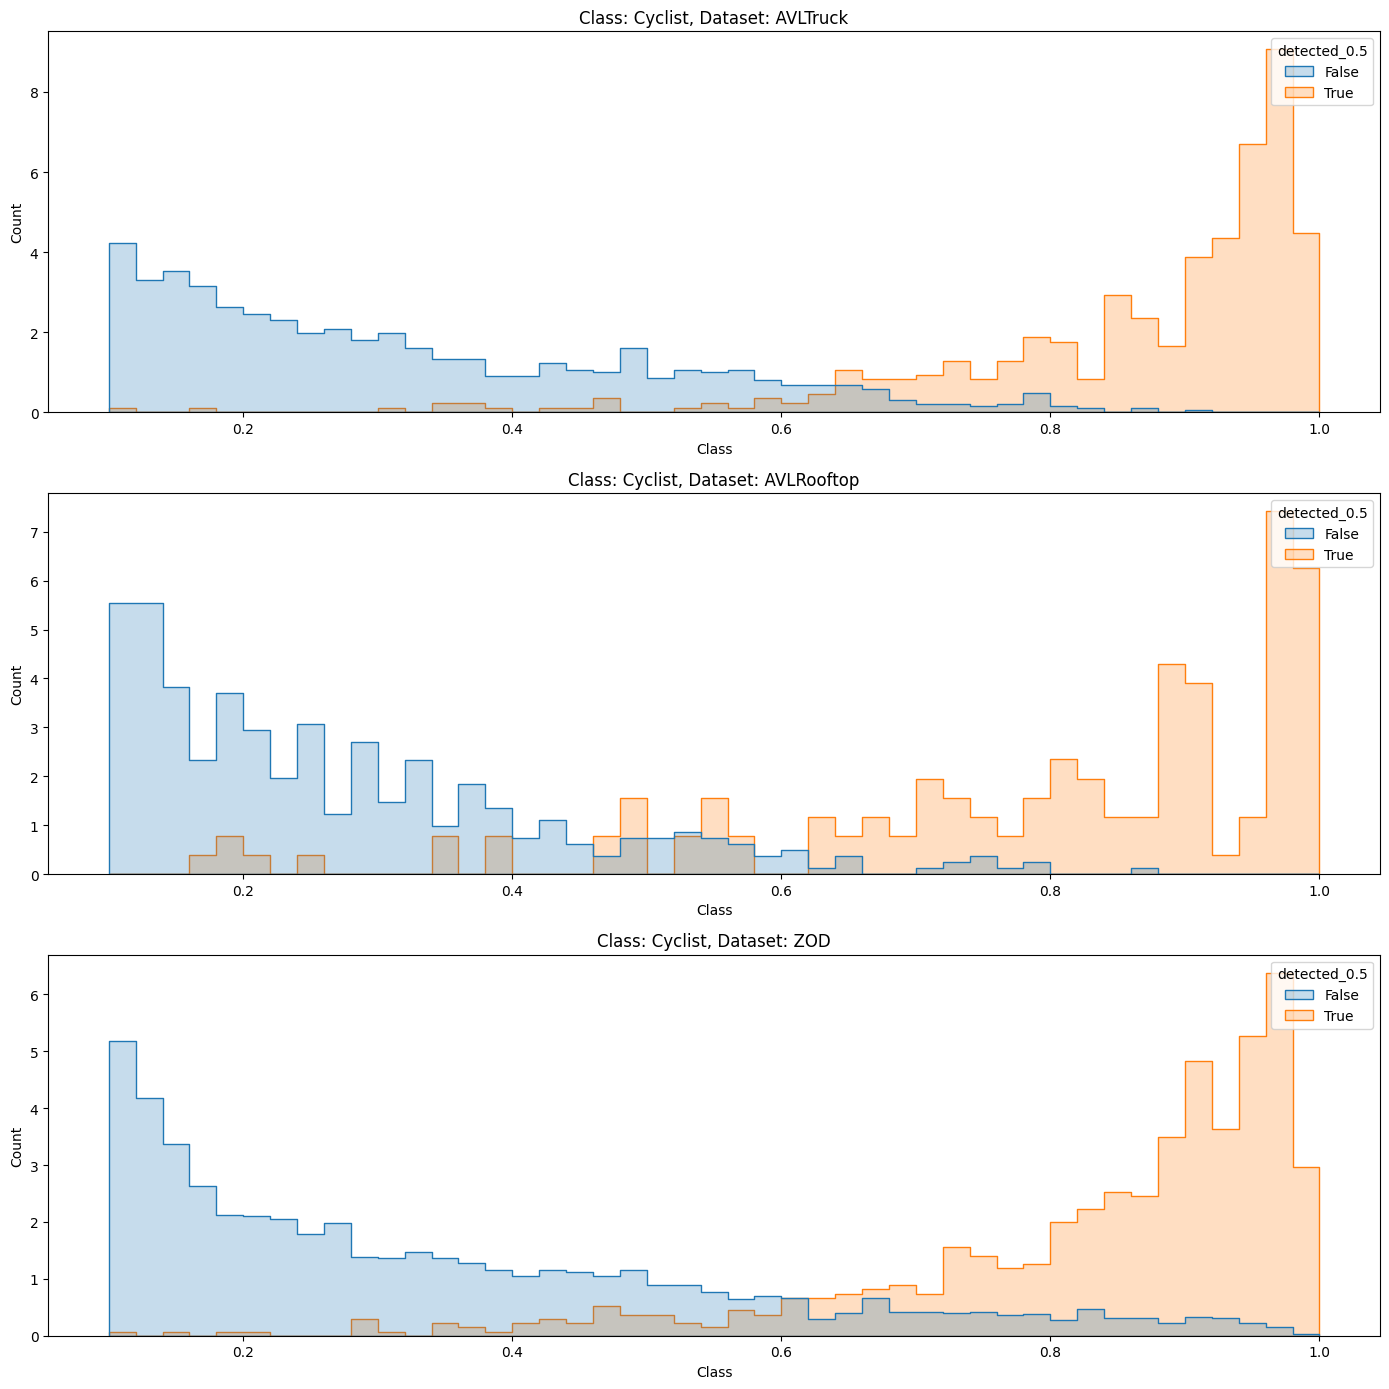

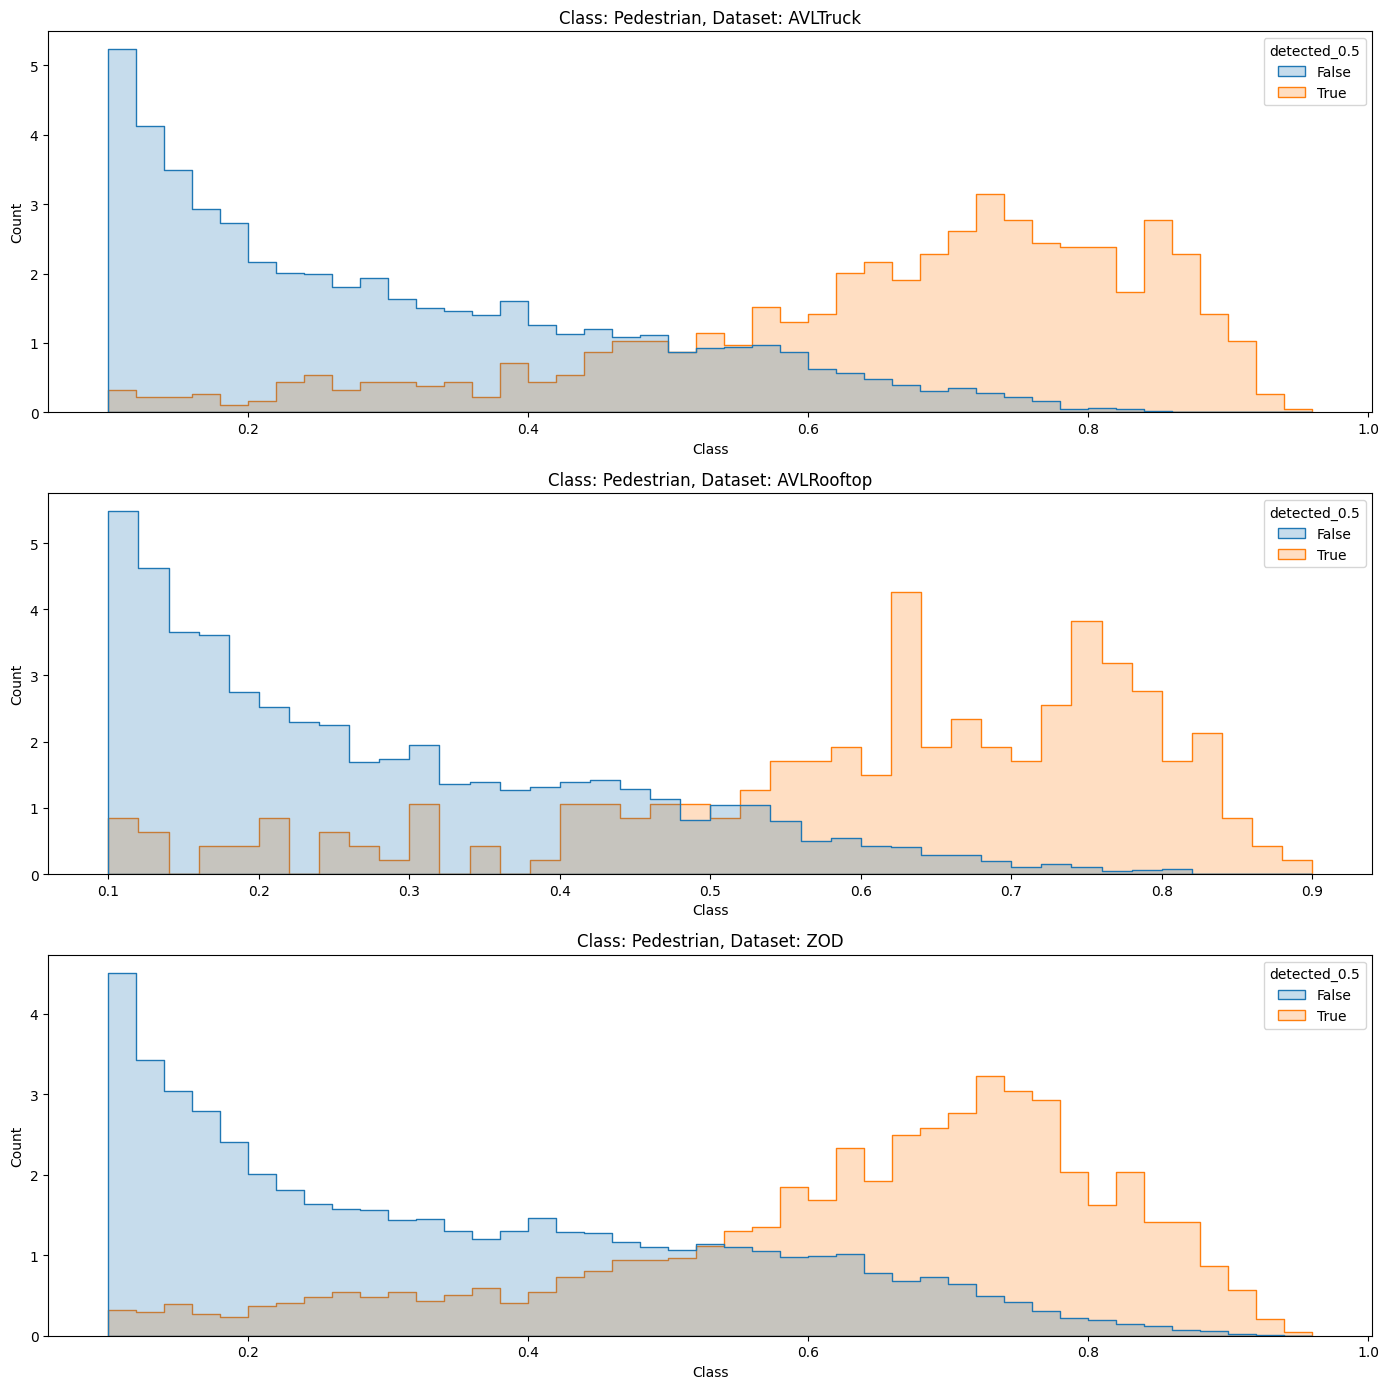

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

iou_threshold = 0.5
classes = df_det['name'].unique()
print("classes are", classes)

for cls in classes:
    #make one subplot per class
    fig, axs = plt.subplots(len(dataset_names),1, figsize=(14, 14))

    for i, dataset in enumerate(dataset_names):
        #select data for the current class and dataset
        df_plot = df_det[(df_det['dataset'] == dataset) & (df_det['name'] == cls)]

        #create a bar chart for the current dataset
        sns.histplot(data=df_plot, x='score', hue=f'detected_{iou_threshold}', element='step', binwidth=0.02, stat='density', common_norm=False, kde=False, ax=axs[i])
        axs[i].set_xlabel("Class")
        axs[i].set_ylabel("Count")
        axs[i].set_title(f"Class: {cls}, Dataset: {dataset}")   

    plt.tight_layout()
    plt.show()


### Plot confidence stores of all detections

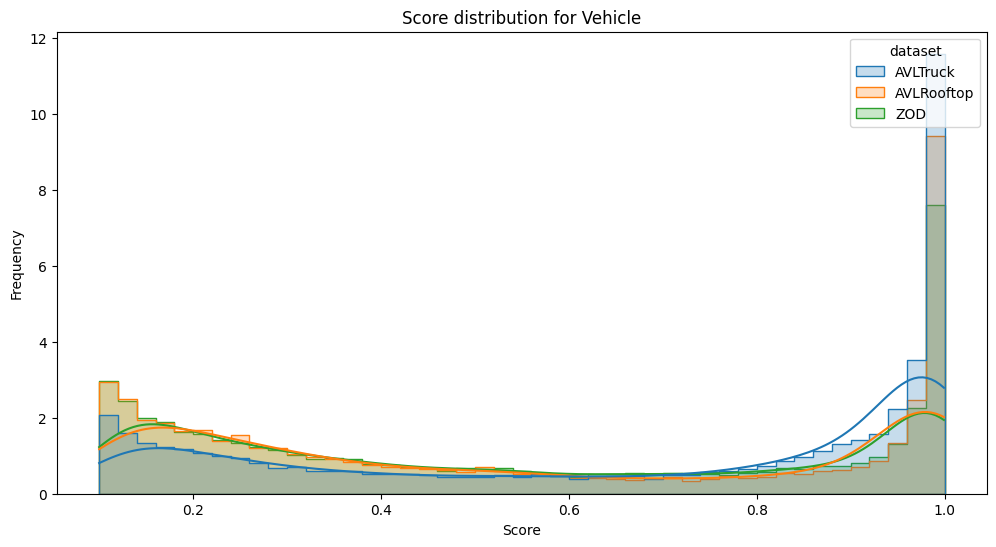

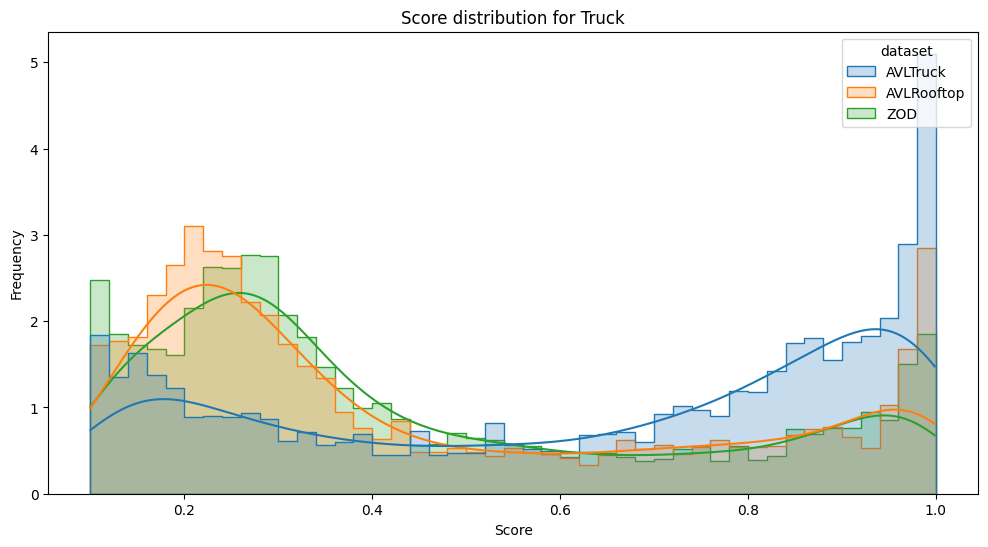

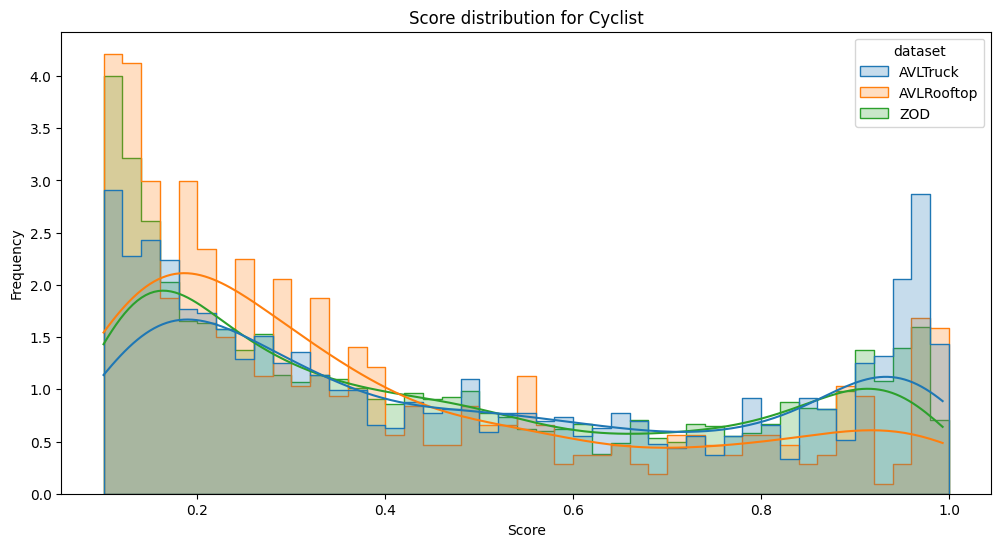

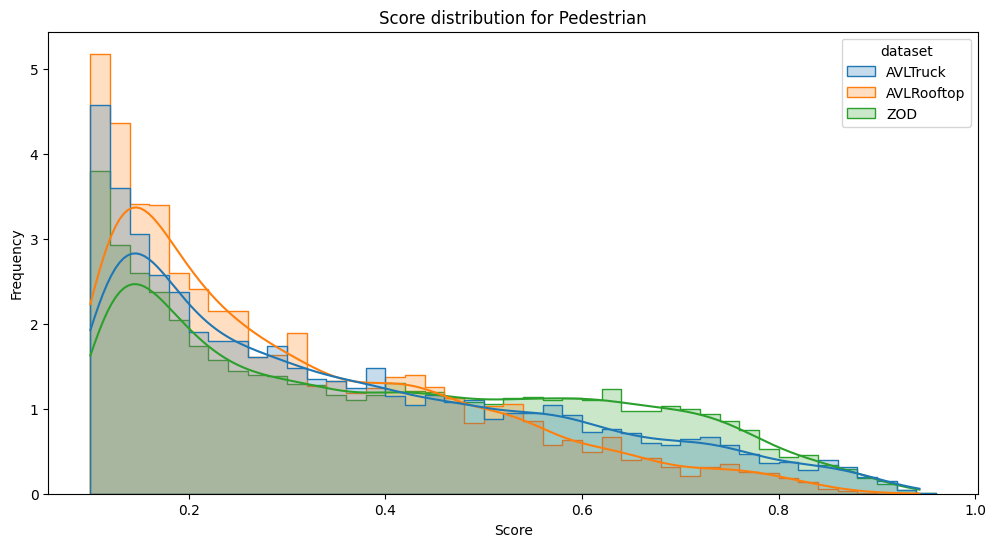

In [8]:


classes = df_det['name'].unique()

for cls in classes: 
    # Create a histogram
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df_det[df_det['name'] == cls] , x='score', hue='dataset', kde=True, element='step', binwidth=0.02, stat='density', common_norm=False)

    # Add labels and title
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title(f'Score distribution for {cls}')

    # Show the plot
    plt.show()